In [1]:
# This notebook extracts daily SST time-series from the ESA-CCI L4 analysis dataset v2.1 available here
# https://data.ceda.ac.uk/neodc/esacci/sst/data/CDR_v2/Analysis/L4/v2.1
# The time series are extracted on an area that is 0.2 deg wide.
# Daily data are converted to monthly data and then some temporal stats are computed.

# From the daily data I can compute a single annual file with the monthly means with
#     cdo -monmean -cat '2010*nc' monthly_2010.nc
# NB: I recursively link the daily files in the same (annual) folder with 
#     ln -r -s */*/*1-v* . 

# For Chl-a I download data from https://catalogue.ceda.ac.uk/uuid/e9f82908fd9c48138b31e5cfaa6d692b with
#     wget -e robots=off --mirror --no-parent -r https://dap.ceda.ac.uk/neodc/esacci/ocean_colour/data/v5.0-release/geographic/netcdf/chlor_a/monthly/v5.0/2008/ 
# being in /media/agostino/sailboat (and selecting the various years).
# ESA CCI Ocean Color dataset (L3 Chl-a on a geographical projection on a monthly basis at 4 km grid spacing).
# I also download the Kd coeff with
#    wget -e robots=off --mirror --no-parent -r https://dap.ceda.ac.uk/neodc/esacci/ocean_colour/data/v5.0-release/geographic/netcdf/kd/monthly/v5.0/2007/

# I download the monthly cloud data products with
#    wget -r -nH -e robots=off --cut-dirs=7 --no-parent --reject="index.html*" https://public.satproj.klima.dwd.de/data/ESA_Cloud_CCI/CLD_PRODUCTS/v3.0/L3C/AVHRR-AM/AVHRR_METOPA/2007
# being in /media/agostino/sailboat/satproj_klima_dwd/ESA_CLoud_CCI/CLD_PRODUCTS/v3.0/L3C/AVHRR-AM/AVHRR_METOPA

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from glob import glob

In [3]:
def plot_background(ax):
    #ax.set_extent(extent_param)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    #ax.add_feature(cfeature.STATES, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'fontsize': 14}
    gl.ylabel_style = {'fontsize': 14}
    return ax

In [4]:
# Read the file with the location of the sediments

filename = 'DB_27122022.csv'
df_loc = pd.read_csv(filename,sep='\t')
wd_all = df_loc['Water depth'].values

df_loc

,LAT,LONG,Water depth,Stations/Facies
0,-16.50,-151.80,10.0,BB14
1,-16.50,-151.80,0.5,BB19
2,-16.50,-151.80,3.0,BB28
3,-16.50,-151.80,13.0,BB1
4,-16.50,-151.80,22.0,BB2
...,...,...,...,...
2259,-26.07,32.95,2.5,T6Pontatorres_3
2260,-26.07,32.95,5.0,T6Pontatorres_4
2261,-26.07,32.95,6.5,T6Pontatorres_5
2262,-26.07,32.95,7.0,T6Pontatorres_6


In [8]:
# Set the path to SST files
path2sst = '/media/agostino/sailboat/neodc/esacci/sst/data/CDR_v2/Analysis/L4/v2.1/'
path2chla = '/media/agostino/sailboat/dap.ceda.ac.uk/neodc/esacci/ocean_colour/data/v5.0-release/geographic/netcdf/chlor_a/monthly/v5.0/'
path2kd = '/media/agostino/sailboat/dap.ceda.ac.uk/neodc/esacci/ocean_colour/data/v5.0-release/geographic/netcdf/kd/monthly/v5.0/'
path2sw = '/media/agostino/sailboat/satproj_klima_dwd/ESA_CLoud_CCI/CLD_PRODUCTS/v3.0/L3C/AVHRR-AM/AVHRR_METOPA/'

# Set the time window in which data are available at the monthly res.
str_start = '2008-01-01' #'YYYY-MM-DD' # '2007-01-01' for SST and CHLA, '2008-01-01' for KD
str_end = '2013-12-01'
instant_start = np.datetime64(str_start)
instant_end = np.datetime64(str_end)

# Set the half width of the box over which to take the average.
dlat = 0.1
dlon = 0.1
dlonn = 0.2
dlatt = 0.2
dlonnn = 0.5
dlattt = 0.5

In [37]:
# Analysis on SST and Chla.

allstats_db = np.array(['LONG','LAT','Water depth','Stations/Facies',
                        'SSTmin_K','SSTavg_K','SSTmax_K',
                        'SSTJan_K','SSTFeb_K','SSTMar_K','SSTApr_K','SSTMay_K','SSTJun_K',
                        'SSTJul_K','SSTAug_K','SSTSep_K','SSTOct_K','SSTNov_K','SSTDec_K',
                        'Chlamin_mg_m-3','Chlaavg_mg_m-3','Chlamax_mg_m-3',
                        'ChlaJan_mg_m-3','ChlaFeb_mg_m-3','ChlaMar_mg_m-3','ChlaApr_mg_m-3','ChlaMay_mg_m-3','ChlaJun_mg_m-3',
                        'ChlaJul_mg_m-3','ChlaAug_mg_m-3','ChlaSep_mg_m-3','ChlaOct_mg_m-3','ChlaNov_mg_m-3','ChlaDec_mg_m-3'
                       ])

list_of_nans_sst = []
list_of_nans_chla = []

for ss in np.arange(700,701): #range(len(df_loc['LONG'])): # Loop on the sites.
    # Select the point.
    lon0 = df_loc['LONG'][ss]
    lat0 = df_loc['LAT'][ss]
    wd0 = df_loc['Water depth'][ss]
    sf0 = str(df_loc['Stations/Facies'][ss])
    
    print('--------------------------------------------')
    print(sf0 + ' at ' + str(wd0) +' m')
    print(str(ss) +' out of '+ str(len(df_loc['LONG'])))
    print('--------------------------------------------')

    # Time loop
    instant = instant_start
    it_s_the_first_instant = True
    time_series = []
    sst_series = []
    chla_series = []
    sst_seasonal = np.zeros(12) # To compute the seasonal cycle
    sst_seasonal_count = np.zeros(12)
    chla_seasonal = np.zeros(12)
    chla_seasonal_count = np.zeros(12)
    nyears = 0 # Number of years.

    the_area_has_been_extended_sst = False
    the_area_has_been_extended_chla = False
    
    while instant <= instant_end:
        print(instant)
        pd_instant = pd.to_datetime(instant)
        year_oi = str(pd_instant.year).zfill(4)

        # Read the annual SST file.
        path_sst_oi = path2sst + '/' +  year_oi + '/'
        filename_sst = 'monthly_'+year_oi+'.nc'
        ds_sst = xr.open_dataset(path_sst_oi + filename_sst)

        # Set the path of the monthly Chla data for the current year.
        path_chla_oi = path2chla + '/' +  year_oi + '/'

        for mm in range(12):
            # Define the monthly time step in the time_series.
            month_oi = str(mm+1).zfill(2)
            time_series.extend([year_oi + '-' + month_oi])
            
            # Read the pointwise SST value.
            sst0 = ds_sst['analysed_sst'][mm].sel(lon=slice(lon0-dlon,lon0+dlon),
                                                  lat=slice(lat0-dlat,lat0+dlat)).mean(dim=['lon','lat'],skipna=True).values
            if np.isnan(sst0): # Extend the area over which the sst is read.
                sst0 = ds_sst['analysed_sst'][mm].sel(lon=slice(lon0-dlonn,lon0+dlonn),
                                                      lat=slice(lat0-dlatt,lat0+dlatt)).mean(dim=['lon','lat'],skipna=True).values
                the_area_has_been_extended_sst = True
                
            sst_series.extend([sst0.item()])
            sst_seasonal[mm] += sst0
            sst_seasonal_count[mm] += 1
            #print(sst_series)
            
            # Read the Chl-a data.
            filename_chla = 'ESACCI-OC-L3S-CHLOR_A-MERGED-1M_MONTHLY_4km_GEO_PML_OCx-'+year_oi+month_oi+'-fv5.0.nc'
            ds_chla = xr.open_dataset(path_chla_oi + filename_chla)

            chla0 = ds_chla['chlor_a'][0].sel(lon=slice(lon0-dlon,lon0+dlon),
                                              lat=slice(lat0+dlat,lat0-dlat)).mean(dim=['lon','lat'],skipna=True).values
            if np.isnan(chla0): # Extend the area over which the sst is read.
                chla0 = ds_chla['chlor_a'][0].sel(lon=slice(lon0-dlonn,lon0+dlonn),
                                                 lat=slice(lat0-dlatt,lat0+dlatt)).mean(dim=['lon','lat'],skipna=True).values
                the_area_has_been_extended_chla = True

            chla_series.extend([chla0.item()])
            chla_seasonal[mm] += chla0
            chla_seasonal_count[mm] += 1

            if it_s_the_first_instant:
                # Check the position of the point on a map.
                crs = ccrs.PlateCarree()
                lon_sst = ds_sst['lon'].values
                lat_sst = ds_sst['lat'].values
                l4_sst = ds_sst['analysed_sst'].values
                lon_chla = ds_chla['lon'].values
                lat_chla = ds_chla['lat'].values
                chla_map = ds_chla['chlor_a'].values

                it_s_the_first_instant = False
                
        instant = np.datetime64(str(int(year_oi)+1)+'-01-01') #+= np.timedelta64(1,'Y')
        nyears += 1
    
    if the_area_has_been_extended_sst:
        list_of_nans_sst.append(sf0+'_at_'+str(wd0))
        print('sst:',list_of_nans_sst)    
    if the_area_has_been_extended_chla:
        list_of_nans_chla.append(sf0+'_at_'+str(wd0))
        print('chla:',list_of_nans_chla)

    # Compute the statistics of interest for SST and Chla.
    sst_t = np.array(sst_series)
    sst_min = np.nanmin(sst_t)
    sst_max = np.nanmax(sst_t)
    sst_avg = np.nanmean(sst_t)
    sst_seasonal_cycle = sst_seasonal/sst_seasonal_count 
    sst_stats = np.concatenate((np.array([lon0,lat0,wd0,sf0,sst_min,sst_avg,sst_max]),sst_seasonal_cycle))
    
    chla_t = np.array(chla_series)
    chla_min = np.nanmin(chla_t)
    chla_max = np.nanmax(chla_t)
    chla_avg = np.nanmean(chla_t)
    chla_seasonal_cycle = chla_seasonal/chla_seasonal_count 
    chla_stats = np.concatenate((np.array([chla_min,chla_avg,chla_max]),chla_seasonal_cycle))
    
    allstats_db = np.vstack([allstats_db,np.concatenate([sst_stats,chla_stats])])
    
    #print(allstats_db)
    
pd.DataFrame(allstats_db).to_csv('stats_prova.csv')
pd.DataFrame(list_of_nans_sst).to_csv('list_sites_larger_area_sst.csv')
pd.DataFrame(list_of_nans_chla).to_csv('list_sites_larger_area_chla.csv')

--------------------------------------------
HSB41 at 5.0 m
700 out of 2264
--------------------------------------------
2008-01-01
2009-01-01
2010-01-01
2011-01-01
2012-01-01
2013-01-01


In [38]:
# Analysis on KD and SW. SW is the shortwave flux at the surface and SWz is at depth, computed as
# SWz = SW*exp(-KD*wd0)

allstats_d2 = np.array(['LONG','LAT','Water depth','Stations/Facies',
                        'KDmin_m-1','KDavg_m-1','KDmax_m-1',
                        'KDJan_m-1','KDFeb_m-1','KDMar_m-1','KDApr_m-1','KDMay_m-1','KDJun_m-1',
                        'KDJul_m-1','KDAug_m-1','KDSep_m-1','KDOct_m-1','KDNov_m-1','KDDec_m-1',
                        'SWmin_W_m-2','SWavg_W_m-2','SWmax_W_m-2',
                        'SWJan_W_m-2','SWFeb_W_m-2','SWMar_W_m-2','SWApr_W_m-2','SWMay_W_m-2','SWJun_W_m-2',
                        'SWJul_W_m-2','SWAug_W_m-2','SWSep_W_m-2','SWOct_W_m-2','SWNov_W_m-2','SWDec_W_m-2',
                        'SWmin_W_m-2','SWavg_W_m-2','SWmax_W_m-2',
                        'SWJan_W_m-2','SWFeb_W_m-2','SWMar_W_m-2','SWApr_W_m-2','SWMay_W_m-2','SWJun_W_m-2',
                        'SWJul_W_m-2','SWAug_W_m-2','SWSep_W_m-2','SWOct_W_m-2','SWNov_W_m-2','SWDec_W_m-2'
                       ])

list_of_nans_kd = []

for ss in np.arange(700,701): #range(len(df_loc['LONG'])): # Loop on the sites.
    # Select the point.
    lon0 = df_loc['LONG'][ss]
    lat0 = df_loc['LAT'][ss]
    wd0 = df_loc['Water depth'][ss]
    sf0 = str(df_loc['Stations/Facies'][ss])
    
    print('--------------------------------------------')
    print(sf0 + ' at ' + str(wd0) +' m')
    print(str(ss) +' out of '+ str(len(df_loc['LONG'])))
    print('--------------------------------------------')

    # Time loop
    instant = instant_start
    it_s_the_first_instant = True
    time_series = []
    kd_series = []
    sw_series = []
    swz_series = []
    kd_seasonal = np.zeros(12) # To compute the seasonal cycle
    kd_seasonal_count = np.zeros(12)
    sw_seasonal = np.zeros(12)
    sw_seasonal_count = np.zeros(12)
    swz_seasonal = np.zeros(12)
    swz_seasonal_count = np.zeros(12)
    nyears = 0 # Number of years.

    the_area_has_been_extended_kd = False
    the_area_has_been_extended_sw = False

    while instant <= instant_end:
        print(instant)
        pd_instant = pd.to_datetime(instant)
        year_oi = str(pd_instant.year).zfill(4)

        # Set the path of the monthly Chla data for the current year.
        path_kd_oi = path2kd + '/' +  year_oi + '/'
        path_sw_oi = path2sw + '/' +  year_oi + '/'

        for mm in range(12):
            # Define the monthly time step in the time_series.
            month_oi = str(mm+1).zfill(2)
            time_series.extend([year_oi + '-' + month_oi])
                        
            # Read the KD data.
            filename_kd = 'ESACCI-OC-L3S-K_490-MERGED-1M_MONTHLY_4km_GEO_PML_KD490_Lee-'+year_oi+month_oi+'-fv5.0.nc'
            ds_kd = xr.open_dataset(path_kd_oi + filename_kd)

            kd0 = ds_kd['kd_490'][0].sel(lon=slice(lon0-dlon,lon0+dlon),
                                         lat=slice(lat0+dlat,lat0-dlat)).mean(dim=['lon','lat'],skipna=True).values
            if np.isnan(kd0): # Extend the area over which the sst is read.
                dlonn = 0.2
                dlatt = 0.2
                kd0 = ds_kd['kd_490'][0].sel(lon=slice(lon0-dlonn,lon0+dlonn),
                                             lat=slice(lat0-dlatt,lat0+dlatt)).mean(dim=['lon','lat'],skipna=True).values
                the_area_has_been_extended_kd = True

            kd_series.extend([kd0.item()])
            kd_seasonal[mm] += kd0
            kd_seasonal_count[mm] += 1

            # Read the SW data. 
            # There should not be NaN, as the data are gap-free and are defined over land, as well.
            # Both fluxes are positive and the upward is smaller than the downward.
            filename_sw = year_oi+month_oi+'-ESACCI-L3C_CLOUD-CLD_PRODUCTS-AVHRR_METOPA-fv3.0.nc'
            ds_sw = xr.open_dataset(path_sw_oi + filename_sw)

            swup0 = ds_sw['boa_swup'][0].sel(lon=slice(lon0-dlonnn,lon0+dlonnn),
                                             lat=slice(lat0-dlattt,lat0+dlattt)).mean(dim=['lon','lat'],skipna=True).values
            swdn0 = ds_sw['boa_swdn'][0].sel(lon=slice(lon0-dlonnn,lon0+dlonnn),
                                             lat=slice(lat0-dlattt,lat0+dlattt)).mean(dim=['lon','lat'],skipna=True).values
            #print('swup',swup0,'swdn',swdn0)
            
            # Compute the net shortwave flux.
            sw0 = swdn0-swup0
                
            sw_series.extend([sw0.item()])
            sw_seasonal[mm] += sw0
            sw_seasonal_count[mm] += 1
            
            # Approximately compute the net shortwave flux at depth.
            swz0 = sw0*np.exp(-kd0*wd0)
            
            swz_series.extend([swz0.item()])
            swz_seasonal[mm] += swz0
            swz_seasonal_count[mm] += 1
            
            if it_s_the_first_instant:
                # Check the position of the point on a map.
                crs = ccrs.PlateCarree()
                lon_kd = ds_kd['lon'].values
                lat_kd = ds_kd['lat'].values
                kd_map = ds_kd['kd_490'].values
                lon_sw = ds_sw['lon'].values
                lat_sw = ds_sw['lat'].values
                swup_map = ds_sw['boa_swup'].values
                swdn_map = ds_sw['boa_swdn'].values

                it_s_the_first_instant = False
                
        instant = np.datetime64(str(int(year_oi)+1)+'-01-01') #+= np.timedelta64(1,'Y')
        nyears += 1
        
    if the_area_has_been_extended_kd:
        list_of_nans_kd.append(sf0+'_at_'+str(wd0))
        print('kd:',list_of_nans_kd)    

    # Compute the statistics of interest for SST and Chla.
    kd_t = np.array(kd_series)
    kd_min = np.nanmin(kd_t)
    kd_max = np.nanmax(kd_t)
    kd_avg = np.nanmean(kd_t)
    kd_seasonal_cycle = kd_seasonal/kd_seasonal_count 
    kd_stats = np.concatenate((np.array([lon0,lat0,wd0,sf0,kd_min,kd_avg,kd_max]),kd_seasonal_cycle))
    
    sw_t = np.array(sw_series)
    sw_min = np.nanmin(sw_t)
    sw_max = np.nanmax(sw_t)
    sw_avg = np.nanmean(sw_t)
    sw_seasonal_cycle = sw_seasonal/sw_seasonal_count 
    sw_stats = np.concatenate((np.array([sw_min,sw_avg,sw_max]),sw_seasonal_cycle))

    swz_t = np.array(swz_series)
    swz_min = np.nanmin(swz_t)
    swz_max = np.nanmax(swz_t)
    swz_avg = np.nanmean(swz_t)
    swz_seasonal_cycle = swz_seasonal/swz_seasonal_count 
    swz_stats = np.concatenate((np.array([swz_min,swz_avg,swz_max]),swz_seasonal_cycle))

    allstats_d2 = np.vstack([allstats_d2,np.concatenate([kd_stats,sw_stats,swz_stats])])
    
    #print(allstats_db)
    
pd.DataFrame(allstats_d2).to_csv('stats_prov2.csv')
pd.DataFrame(list_of_nans_kd).to_csv('list_sites_larger_area_kd.csv')


--------------------------------------------
HSB41 at 5.0 m
700 out of 2264
--------------------------------------------
2008-01-01
2009-01-01
2010-01-01
2011-01-01
2012-01-01
2013-01-01


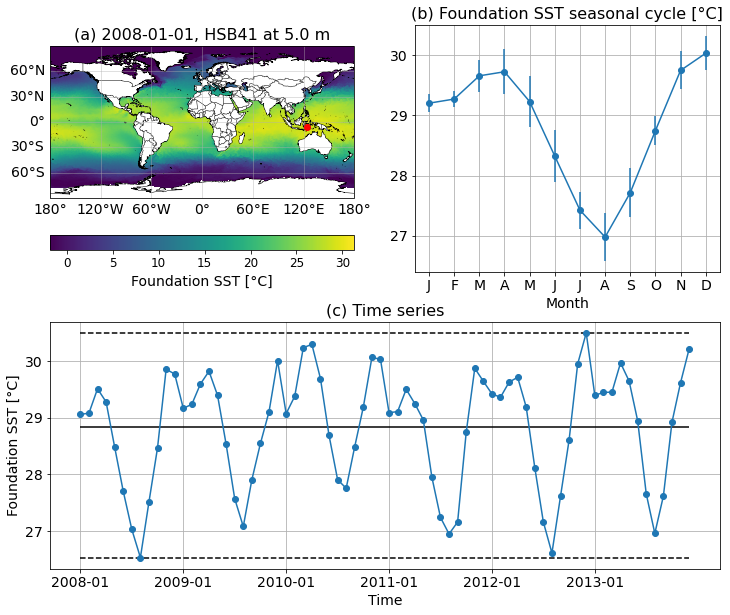

In [39]:
# Plot a map, the seasonal cycle and the full time series for SST.
fig = plt.figure(figsize=(12,10))

ax1 = fig.add_subplot(2,2,1,projection=crs)
plot_background(ax1)
pc1 = ax1.pcolormesh(lon_sst,lat_sst,l4_sst[0]-273.15,shading='nearest',transform=ccrs.PlateCarree())
cbar1 = plt.colorbar(pc1, orientation = 'horizontal')
cbar1.ax.tick_params(labelsize=12) 
ax1.plot(lon0,lat0,'or')
ax1.plot([lon0-dlon,lon0+dlon,lon0+dlon,lon0-dlon,lon0-dlon],
         [lat0-dlat,lat0-dlat,lat0+dlat,lat0+dlat,lat0-dlat],'red')
cbar1.set_label('Foundation SST [°C]',size=14)
ax1.set_title('(a) ' + str_start+', '+sf0+' at '+str(wd0)+' m', fontsize=16)

ax2 = fig.add_subplot(2,2,2)
#ax2.plot(np.arange(1,13),sst_seasonal_cycle-273.15,'o-')
sst_years = sst_t.reshape((nyears,12))
sst_mean_seasonal = np.mean(sst_years,axis=0)-273.15
sst_std_seasonal = np.std(sst_years,axis=0)
ax2.errorbar(np.arange(1,13),sst_mean_seasonal,sst_std_seasonal,fmt='o-')
ax2.tick_params(axis='both',labelsize=14)
ax2.set_title('(b) Foundation SST seasonal cycle [°C]', fontsize=16)
ax2.set_xlabel('Month',fontsize=14)
ax2.set_xticks(np.arange(1,13))
ax2.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.grid()

ax3 = fig.add_subplot(2,1,2)
ax3.plot(time_series,sst_t-273.15,'o-')
ax3.tick_params(axis='both',labelsize=14)
ax3.set_ylabel('Foundation SST [°C]',fontsize=14)
ax3.set_xlabel('Time',fontsize=14)
ax3.set_xticks(np.arange(0,len(sst_series),12))
ax3.set_xticklabels(time_series[::12])
ax3.set_title('(c) Time series', fontsize=16)
plt.grid()
ax3.hlines(sst_max-273.15,time_series[0],time_series[-1],colors='k',linestyles='dashed')
ax3.hlines(sst_min-273.15,time_series[0],time_series[-1],colors='k',linestyles='dashed')
ax3.hlines(sst_avg-273.15,time_series[0],time_series[-1],colors='k',linestyles='solid')

figure_name = 'map_time_series_sst_'+sf0+'_'+str(wd0)+'.png'
plt.savefig(figure_name,bbox_inches='tight')

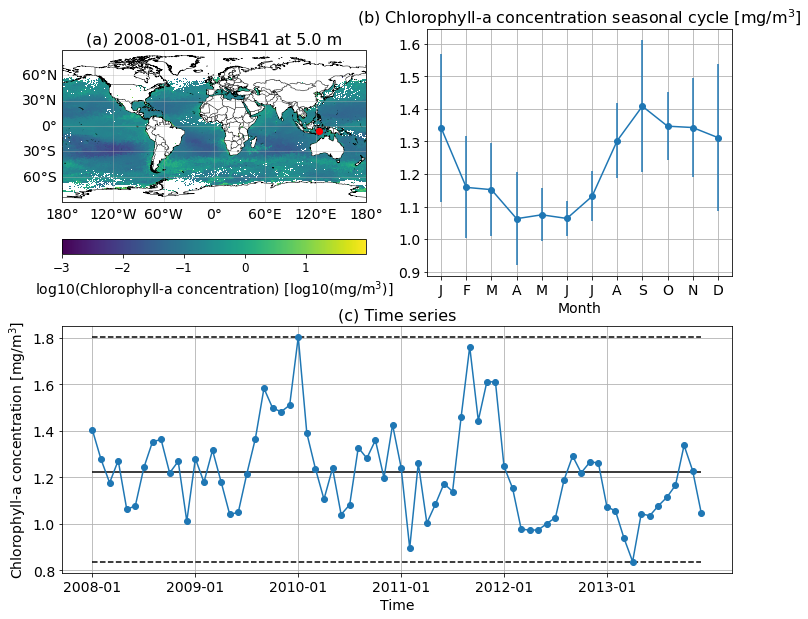

In [40]:
# Map of Chla.

fig = plt.figure(figsize=(12,10))

ax1 = fig.add_subplot(2,2,1,projection=crs)
plot_background(ax1)
pc1 = ax1.pcolormesh(lon_chla,lat_chla,np.log10(chla_map[0]),shading='nearest',transform=ccrs.PlateCarree())
cbar1 = plt.colorbar(pc1, orientation = 'horizontal')
cbar1.ax.tick_params(labelsize=12) 
ax1.plot(lon0,lat0,'or')
ax1.plot([lon0-dlon,lon0+dlon,lon0+dlon,lon0-dlon,lon0-dlon],
         [lat0-dlat,lat0-dlat,lat0+dlat,lat0+dlat,lat0-dlat],'red')
cbar1.set_label('log10(Chlorophyll-a concentration) [log10(mg/m$^3$)]',size=14)
ax1.set_title('(a) ' + str_start+', '+sf0+' at '+str(wd0)+' m', fontsize=16)

ax2 = fig.add_subplot(2,2,2)
#ax2.plot(np.arange(1,13),chla_seasonal_cycle,'o-')
chla_years = chla_t.reshape((nyears,12))
chla_mean_seasonal = np.mean(chla_years,axis=0)
chla_std_seasonal = np.std(chla_years,axis=0)
ax2.errorbar(np.arange(1,13),chla_mean_seasonal,chla_std_seasonal,fmt='o-')
ax2.tick_params(axis='both',labelsize=14)
ax2.set_title('(b) Chlorophyll-a concentration seasonal cycle [mg/m$^3$]', fontsize=16)
ax2.set_xlabel('Month',fontsize=14)
ax2.set_xticks(np.arange(1,13))
ax2.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.grid()

ax3 = fig.add_subplot(2,1,2)
ax3.plot(time_series,chla_t,'o-')
ax3.tick_params(axis='both',labelsize=14)
ax3.set_ylabel('Chlorophyll-a concentration [mg/m$^3$]',fontsize=14)
ax3.set_xlabel('Time',fontsize=14)
ax3.set_xticks(np.arange(0,len(sst_series),12))
ax3.set_xticklabels(time_series[::12])
ax3.set_title('(c) Time series', fontsize=16)
plt.grid()
ax3.hlines(chla_max,time_series[0],time_series[-1],colors='k',linestyles='dashed')
ax3.hlines(chla_min,time_series[0],time_series[-1],colors='k',linestyles='dashed')
ax3.hlines(chla_avg,time_series[0],time_series[-1],colors='k',linestyles='solid')

figure_name = 'map_time_series_chla_'+sf0+'_'+str(wd0)+'.png'
plt.savefig(figure_name,bbox_inches='tight')

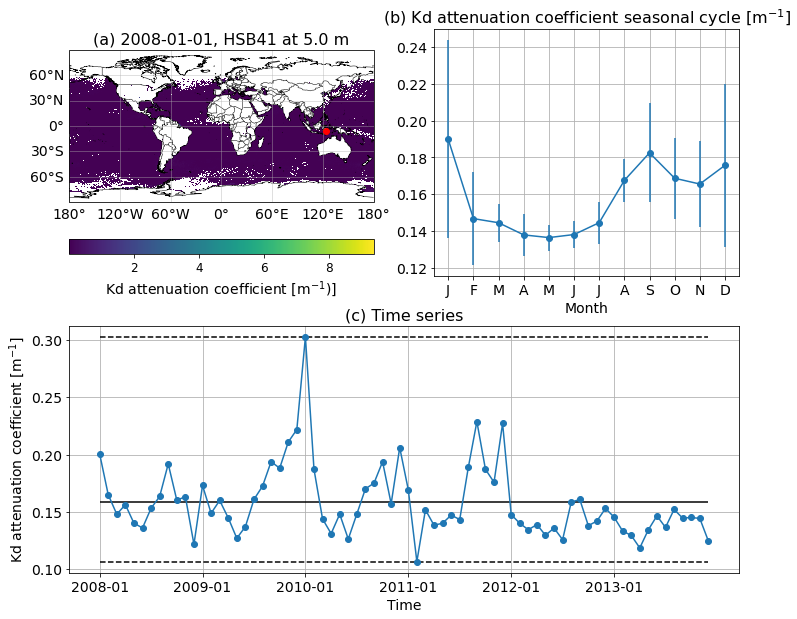

In [41]:
# Map of Kd.

fig = plt.figure(figsize=(12,10))

ax1 = fig.add_subplot(2,2,1,projection=crs)
plot_background(ax1)
pc1 = ax1.pcolormesh(lon_kd,lat_kd,kd_map[0],shading='nearest',transform=ccrs.PlateCarree())
cbar1 = plt.colorbar(pc1, orientation = 'horizontal')
cbar1.ax.tick_params(labelsize=12) 
ax1.plot(lon0,lat0,'or')
ax1.plot([lon0-dlon,lon0+dlon,lon0+dlon,lon0-dlon,lon0-dlon],
         [lat0-dlat,lat0-dlat,lat0+dlat,lat0+dlat,lat0-dlat],'red')
cbar1.set_label('Kd attenuation coefficient [m$^{-1}$)]',size=14)
ax1.set_title('(a) ' + str_start+', '+sf0+' at '+str(wd0)+' m', fontsize=16)

ax2 = fig.add_subplot(2,2,2)
kd_years = kd_t.reshape((nyears,12))
kd_mean_seasonal = np.mean(kd_years,axis=0)
kd_std_seasonal = np.std(kd_years,axis=0)
ax2.errorbar(np.arange(1,13),kd_mean_seasonal,kd_std_seasonal,fmt='o-')
ax2.tick_params(axis='both',labelsize=14)
ax2.set_title('(b) Kd attenuation coefficient seasonal cycle [m$^{-1}$]', fontsize=16)
ax2.set_xlabel('Month',fontsize=14)
ax2.set_xticks(np.arange(1,13))
ax2.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.grid()

ax3 = fig.add_subplot(2,1,2)
ax3.plot(time_series,kd_t,'o-')
ax3.tick_params(axis='both',labelsize=14)
ax3.set_ylabel('Kd attenuation coefficient [m$^{-1}$]',fontsize=14)
ax3.set_xlabel('Time',fontsize=14)
ax3.set_xticks(np.arange(0,len(kd_series),12))
ax3.set_xticklabels(time_series[::12])
ax3.set_title('(c) Time series', fontsize=16)
plt.grid()
ax3.hlines(kd_max,time_series[0],time_series[-1],colors='k',linestyles='dashed')
ax3.hlines(kd_min,time_series[0],time_series[-1],colors='k',linestyles='dashed')
ax3.hlines(kd_avg,time_series[0],time_series[-1],colors='k',linestyles='solid')

figure_name = 'map_time_series_kd_'+sf0+'_'+str(wd0)+'.png'
plt.savefig(figure_name,bbox_inches='tight')

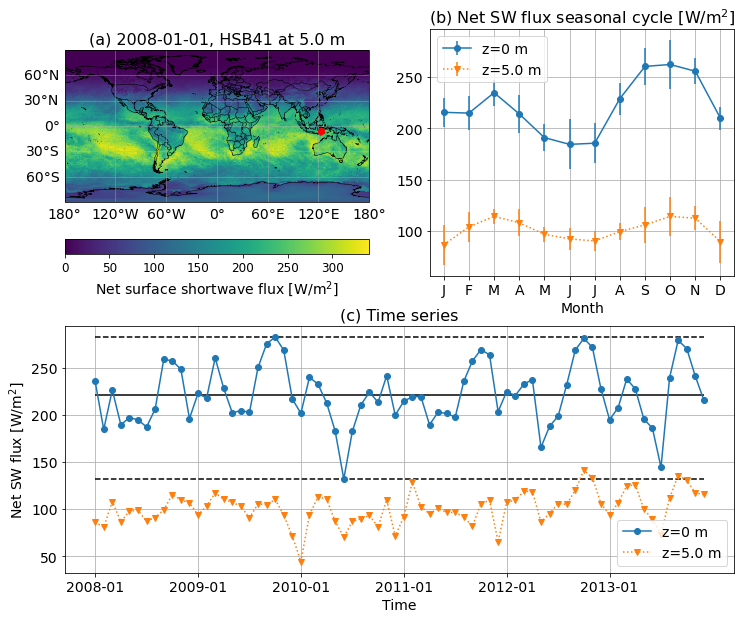

In [42]:
# Map of SW.

fig = plt.figure(figsize=(12,10))

ax1 = fig.add_subplot(2,2,1,projection=crs)
plot_background(ax1)
pc1 = ax1.pcolormesh(lon_sw,lat_sw,swdn_map[0]-swup_map[0],shading='nearest',transform=ccrs.PlateCarree())
cbar1 = plt.colorbar(pc1, orientation = 'horizontal')
cbar1.ax.tick_params(labelsize=12) 
ax1.plot(lon0,lat0,'or')
ax1.plot([lon0-dlonnn,lon0+dlonnn,lon0+dlonnn,lon0-dlonnn,lon0-dlonnn],
         [lat0-dlattt,lat0-dlattt,lat0+dlattt,lat0+dlattt,lat0-dlattt],'red')
cbar1.set_label('Net surface shortwave flux [W/m$^2$]',size=14)
ax1.set_title('(a) ' + str_start+', '+sf0+' at '+str(wd0)+' m', fontsize=16)

ax2 = fig.add_subplot(2,2,2)
sw_years = sw_t.reshape((nyears,12))
sw_mean_seasonal = np.mean(sw_years,axis=0)
sw_std_seasonal = np.std(sw_years,axis=0)
ax2.errorbar(np.arange(1,13),sw_mean_seasonal,sw_std_seasonal,fmt='o-',label='z=0 m')
swz_years = swz_t.reshape((nyears,12))
swz_mean_seasonal = np.mean(swz_years,axis=0)
swz_std_seasonal = np.std(swz_years,axis=0)
ax2.errorbar(np.arange(1,13),swz_mean_seasonal,swz_std_seasonal,fmt='v:',label='z='+str(wd0)+' m')
ax2.tick_params(axis='both',labelsize=14)
ax2.set_title('(b) Net SW flux seasonal cycle [W/m$^2$]', fontsize=16)
ax2.set_xlabel('Month',fontsize=14)
ax2.set_xticks(np.arange(1,13))
ax2.legend(fontsize=14)
ax2.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.grid()

ax3 = fig.add_subplot(2,1,2)
ax3.plot(time_series,sw_t,'o-',label='z=0 m')
ax3.plot(time_series,swz_t,'v:',label='z='+str(wd0)+' m')
ax3.tick_params(axis='both',labelsize=14)
ax3.set_ylabel('Net SW flux [W/m$^2$]',fontsize=14)
ax3.set_xlabel('Time',fontsize=14)
ax3.set_xticks(np.arange(0,len(sw_series),12))
ax3.set_xticklabels(time_series[::12])
ax3.set_title('(c) Time series', fontsize=16)
plt.grid()
ax3.legend(fontsize=14)
ax3.hlines(sw_max,time_series[0],time_series[-1],colors='k',linestyles='dashed')
ax3.hlines(sw_min,time_series[0],time_series[-1],colors='k',linestyles='dashed')
ax3.hlines(sw_avg,time_series[0],time_series[-1],colors='k',linestyles='solid')

figure_name = 'map_time_series_sw_'+sf0+'_'+str(wd0)+'.png'
plt.savefig(figure_name,bbox_inches='tight')

In [26]:
# Check the number of nans in the selected stat_db file

db_check = pd.read_csv('stats_db_20230228.csv')
list_col = db_check.columns
print(list_col)
db_check

Index(['Unnamed: 0', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33'],
      dtype='object')


,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,24,25,26,27,28,29,30,31,32,33
0,0,LONG,LAT,Water depth,Stations/Facies,SSTmin_K,SSTavg_K,SSTmax_K,SSTJan_K,SSTFeb_K,...,ChlaMar_mg_m-3,ChlaApr_mg_m-3,ChlaMay_mg_m-3,ChlaJun_mg_m-3,ChlaJul_mg_m-3,ChlaAug_mg_m-3,ChlaSep_mg_m-3,ChlaOct_mg_m-3,ChlaNov_mg_m-3,ChlaDec_mg_m-3
1,1,-151.8,-16.5,10.0,BB14,299.36602783203125,301.0754412696475,302.7432861328125,301.62455095563615,301.80752999441967,...,0.4116018499646868,0.35698296981198446,0.3484946031655584,0.3029797353914806,0.3466857820749283,0.38716572523117065,0.3420978624905859,0.45035475705351147,0.4160634162170546,0.4316747507878712
2,2,-151.8,-16.5,0.5,BB19,299.36602783203125,301.0754412696475,302.7432861328125,301.62455095563615,301.80752999441967,...,0.4116018499646868,0.35698296981198446,0.3484946031655584,0.3029797353914806,0.3466857820749283,0.38716572523117065,0.3420978624905859,0.45035475705351147,0.4160634162170546,0.4316747507878712
3,3,-151.8,-16.5,3.0,BB28,299.36602783203125,301.0754412696475,302.7432861328125,301.62455095563615,301.80752999441967,...,0.4116018499646868,0.35698296981198446,0.3484946031655584,0.3029797353914806,0.3466857820749283,0.38716572523117065,0.3420978624905859,0.45035475705351147,0.4160634162170546,0.4316747507878712
4,4,-151.8,-16.5,13.0,BB1,299.36602783203125,301.0754412696475,302.7432861328125,301.62455095563615,301.80752999441967,...,0.4116018499646868,0.35698296981198446,0.3484946031655584,0.3029797353914806,0.3466857820749283,0.38716572523117065,0.3420978624905859,0.45035475705351147,0.4160634162170546,0.4316747507878712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260,2260,32.95,-26.07,2.5,T6Pontatorres_3,293.83935546875,297.5409240722656,300.91375732421875,300.2789306640625,300.7135750906808,...,3.3081470898219516,3.5435499123164584,3.0549428122384206,3.130023172923497,3.270996570587158,3.503925698144095,3.3448119504111156,3.375789369855608,3.2359865392957414,2.701741797583444
2261,2261,32.95,-26.07,5.0,T6Pontatorres_4,293.83935546875,297.5409240722656,300.91375732421875,300.2789306640625,300.7135750906808,...,3.3081470898219516,3.5435499123164584,3.0549428122384206,3.130023172923497,3.270996570587158,3.503925698144095,3.3448119504111156,3.375789369855608,3.2359865392957414,2.701741797583444
2262,2262,32.95,-26.07,6.5,T6Pontatorres_5,293.83935546875,297.5409240722656,300.91375732421875,300.2789306640625,300.7135750906808,...,3.3081470898219516,3.5435499123164584,3.0549428122384206,3.130023172923497,3.270996570587158,3.503925698144095,3.3448119504111156,3.375789369855608,3.2359865392957414,2.701741797583444
2263,2263,32.95,-26.07,7.0,T6Pontatorres_6,293.83935546875,297.5409240722656,300.91375732421875,300.2789306640625,300.7135750906808,...,3.3081470898219516,3.5435499123164584,3.0549428122384206,3.130023172923497,3.270996570587158,3.503925698144095,3.3448119504111156,3.375789369855608,3.2359865392957414,2.701741797583444


In [27]:
for kk in np.arange(5,len(list_col)):
    varname = db_check[list_col[kk]][0]
    print(varname)
    values = db_check[list_col[kk]][1:].astype(float)
    print(values.dtype)
    nnans = np.sum(np.isnan(values))
    print('Number of nans = '+str(nnans))
    print('-----------------------------------')
    

SSTmin_K
float64
Number of nans = 9
-----------------------------------
SSTavg_K
float64
Number of nans = 9
-----------------------------------
SSTmax_K
float64
Number of nans = 9
-----------------------------------
SSTJan_K
float64
Number of nans = 9
-----------------------------------
SSTFeb_K
float64
Number of nans = 9
-----------------------------------
SSTMar_K
float64
Number of nans = 9
-----------------------------------
SSTApr_K
float64
Number of nans = 9
-----------------------------------
SSTMay_K
float64
Number of nans = 9
-----------------------------------
SSTJun_K
float64
Number of nans = 9
-----------------------------------
SSTJul_K
float64
Number of nans = 9
-----------------------------------
SSTAug_K
float64
Number of nans = 9
-----------------------------------
SSTSep_K
float64
Number of nans = 9
-----------------------------------
SSTOct_K
float64
Number of nans = 9
-----------------------------------
SSTNov_K
float64
Number of nans = 9
----------------------------

In [26]:
# File: stats_db_20230130.csv
# For the SST, the number of nans is always the same (20): it is likely that the coastline is too close to the 
# selected point: we increase the size of the square to 0.2 for those points.
# For Chla the number of nans is different among sample sites.
# File: stats_db_20230224.csv
# For the SST, the number of nans is always the same (14)... this is not expected...
# File: stats_db_20230228.csv
# By increasing the dlonn and dlatt from 0.2 to 0.5, the number of NaNs in SST drops to 9. Still, for Chla, 
# the number of NaNs can be high (up or more than 150).

array(['299.36602783203125', '299.36602783203125', '299.36602783203125',
       ..., '293.83935546875', '293.83935546875', '293.83935546875'],
      dtype=object)

In [59]:
# Set the path to SST files
path2sst = '/media/agostino/sailboat/neodc/esacci/sst/data/CDR_v2/Analysis/L4/v2.1/'
#path2chla

# Set the time window in which data are available
str_start = '2010-12-01' #'YYYY-MM-DD'
str_end = '2010-12-31'

In [24]:
# Set the half width of the box over which to take the average.
dlat = 0.1
dlon = 0.1

# Select the point.
lon0 = df_loc['LONG'][0]
lat0 = df_loc['LAT'][0]

# Time loop
instant_start = np.datetime64(str_start)
instant_end = np.datetime64(str_end)
instant = instant_start
it_s_the_first_instant = True
sst_series = []

while instant <= instant_end:
    print(instant)
    pd_instant = pd.to_datetime(instant)
    year_oi = str(pd_instant.year).zfill(4)
    month_oi = str(pd_instant.month).zfill(2)
    day_oi = str(pd_instant.day).zfill(2)

    # Set the path to the SST data. For a given day, read the L4 daily map over the area of interest.
    path_sst_oi = path2sst + '/' +  year_oi + '/' + month_oi + '/' + day_oi + '/'
    filename_sst = sorted(glob(path_sst_oi + '*2.1-v*')) # this removes the file with the 'anomaly' in their name.
    ds_sst = xr.open_dataset(filename_sst[0])

    sst0 = ds_sst['analysed_sst'].sel(lon=slice(lon0-dlon,lon0+dlon),
                                      lat=slice(lat0-dlat,lat0+dlat)).mean(dim=['lon','lat'],skipna=True).values

    if it_s_the_first_instant:
        # Check the position of the point on a map.
        crs = ccrs.PlateCarree()
        lon_sst = ds_sst['lon'].values
        lat_sst = ds_sst['lat'].values
        l4_sst = ds_sst['analysed_sst'].values
        
        fig = plt.figure(figsize=(20,14))

        ax1 = fig.add_subplot(2, 1, 1, projection=crs)
        plot_background(ax1)
        pc1 = ax1.pcolormesh(lon_sst,lat_sst,l4_sst[0]-273.15,shading='nearest',transform=ccrs.PlateCarree())
        cbar1 = plt.colorbar(pc1)
        cbar1.ax.tick_params(labelsize=12) 
        ax1.plot(lon0,lat0,'or')
        ax1.plot([lon0-dlon,lon0+dlon,lon0+dlon,lon0-dlon,lon0-dlon],
                 [lat0-dlat,lat0-dlat,lat0+dlat,lat0+dlat,lat0-dlat],'red')
        cbar1.set_label('Depth SST [°C]',size=14)
        ax1.set_title(year_oi + '-' + month_oi + '-' + day_oi, fontsize=16)
        
        it_s_the_first_instant = False
    
    print(sst0)
    print(sst0.dtype)
    sst_series.extend(sst0)
    instant += np.timedelta64(1,'D')
        

2007-01-01
[302.252]
float32
2007-01-02
[302.15134]
float32
2007-01-03
[302.158]
float32
2007-01-04
[302.16534]
float32
2007-01-05
[302.23065]
float32
2007-01-06
[302.21]
float32
2007-01-07
[302.1733]
float32
2007-01-08
[302.128]
float32
2007-01-09
[302.16064]
float32
2007-01-10
[302.24265]
float32
2007-01-11
[302.17596]
float32
2007-01-12
[302.06198]
float32
2007-01-13
[302.07468]
float32
2007-01-14
[301.8033]
float32
2007-01-15
[301.7547]
float32
2007-01-16
[301.62534]
float32
2007-01-17
[301.49734]
float32
2007-01-18
[301.45203]
float32
2007-01-19
[301.52597]
float32
2007-01-20
[301.53333]
float32
2007-01-21
[301.622]
float32
2007-01-22
[301.59402]
float32
2007-01-23
[301.46335]
float32
2007-01-24
[301.52597]
float32
2007-01-25
[301.45]
float32
2007-01-26
[301.53333]
float32
2007-01-27
[301.764]
float32
2007-01-28
[301.68536]
float32
2007-01-29
[301.68997]
float32
2007-01-30
[301.67932]
float32
2007-01-31
[301.86465]
float32
2007-02-01
[301.87735]
float32
2007-02-02
[301.86133]
floa

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f3b4c1643a0> (for post_execute):


KeyboardInterrupt: 

302.7444


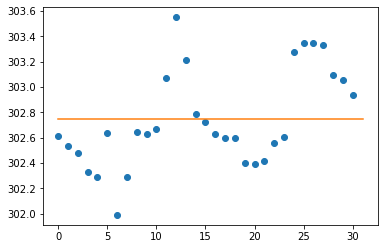

In [50]:
plt.plot(sst_series,'o')
plt.plot([0,len(sst_series)],np.array([1,1])*np.mean(sst_series))
print(np.mean(sst_series))
# JAN

302.23093


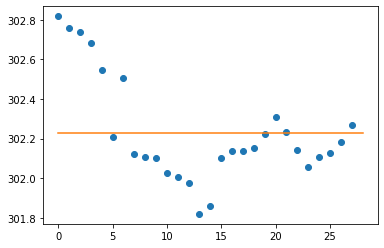

In [58]:
plt.plot(sst_series,'o')
plt.plot([0,len(sst_series)],np.array([1,1])*np.mean(sst_series))
print(np.mean(sst_series))
# FEB

301.2399


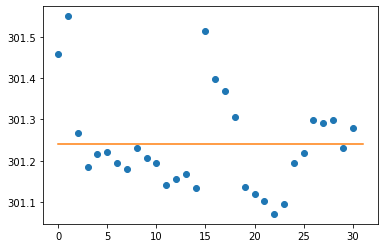

In [61]:
plt.plot(sst_series,'o')
plt.plot([0,len(sst_series)],np.array([1,1])*np.mean(sst_series))
print(np.mean(sst_series))
# DEC

In [54]:
monthly_file = '/media/agostino/sailboat/neodc/esacci/sst/data/CDR_v2/Analysis/L4/v2.1/2010/prova.nc'
ds_m = xr.open_dataset(monthly_file)
sst0 = ds_m['analysed_sst'].sel(lon=slice(lon0-dlon,lon0+dlon),
                                lat=slice(lat0-dlat,lat0+dlat)).mean(dim=['lon','lat'],skipna=True).values

print(sst0)

[302.7433  302.23    302.26602 302.47733 302.18002 301.3493  300.58066
 300.11133 299.81732 300.1327  300.9153  301.23996]
